## Neural Style Transfer - Keras

In this notebook, we will explore and experiment with style transfer. Particularly, grayscale images.

There is no difference with working with a grayscale image expect for the fact in how we pre-process them. Rest every single thing is exactly the same!

## Imports

In [1]:
from __future__ import division,print_function
from PIL import Image
import gc,re

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Input, LSTM, GRU, Embedding, Convolution1D, MaxPooling1D, MaxPool1D
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from importlib import reload
from keras import backend as K
from keras.datasets import imdb

np.random.seed(7)

from keras.preprocessing.image import load_img, img_to_array

import bcolz
from IPython.display import FileLink
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

from scipy.optimize import fmin_l_bfgs_b
from keras import metrics
from scipy.misc import imsave
import imageio

%matplotlib inline

Using TensorFlow backend.


In the cell below, I am forcing Keras to use the 'channels_last' image data format since my backend is tensorflow. This would be set to 'channels_first' for Theano backend

In [2]:
K.set_image_data_format("channels_last")

In [42]:
PATH = 'data/imagenet_sample/'
IMG = 'bb.jpeg'
RESULTS = PATH+'results_2/'

In [330]:
def preprocess_image(img):
    img = img_to_array(img)
    
    #Preprocessing for a grayscale image - (img_height, img_width, 1) to (img_height, img_width,3)
    if img.shape[2] == 1:
        img = img.reshape(img.shape[0], img.shape[1])
        img = gray2rgb(img)
    
    #convert (img_height, img_width, n_channels) to (1,img_height, img_width, n_channels)
    img = np.expand_dims(img, axis=0) # VGG expects images in batches, so we create a batch of 1 here
    img = preprocess_input(img)
    return img

In [5]:
def depreprocess_image(x, shape):

    x = x.reshape(shape)
    x = x + [123.68, 116.779, 103.939] #add the mean of the ImageNet dataset.
    # 'BGR'->'RGB'
    x = x[:, :,:, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x
    

In [6]:
class Evaluator(object):
    def __init__(self, fn, shape):
        self.fn = fn
        self.shape = shape
        
    def get_loss(self, x):
        x = x.reshape(self.shape)
        output = self.fn([x])
        loss = output[0].astype('float64')
        self.grads = np.array(output[1:])
        return loss
    
    def get_grads(self, x):
        return self.grads.flatten().astype('float64')


In [7]:
def solver(eval_obj, iters, x, shape, target = 'content'):
    
    for i in range(iters):
        print("Iteration : " + str(i))
        x, min_value, info = fmin_l_bfgs_b(eval_obj.get_loss, x.flatten(), \
                                           fprime=eval_obj.get_grads, maxfun=20)
        
        x = np.clip(x, -127,127)
        print(" Loss at iteration "+str(i) + " is : "+str(min_value))
        
        # Let us save how the random noise image looks life after each transformation
        BASE_STRING = 'res_at_iteration_'
        NAME = BASE_STRING + target + '_'
        fname = RESULTS+NAME+ str(i) +'.png' 
        imageio.imwrite(fname, depreprocess_image(x.copy(), shape)[0])
    return x

In [8]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)

In [9]:
from IPython.display import HTML
from matplotlib import animation,rc

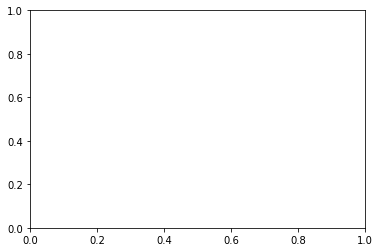

In [10]:
fig, ax = plt.subplots()


In [11]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
    gm = K.dot(features, K.transpose(features))
    gm_normalized = gm / (x.get_shape().num_elements()) # divide by the total elements in that tensor
    return gm_normalized

In [12]:
def style_loss(x,y):
    return metrics.mse(gram_matrix(x), gram_matrix(y))

In [13]:
import scipy
from skimage.color import gray2rgb

## Working With Grayscale Content Images

In the earlier example that we looked at, for the content image transformation, we only took a single conv layer output. Let us now try an example with multiple conv layer output for both content and style image.

In [276]:
IMG = 'mybb.jpg'
new_content_image = Image.open(PATH+IMG)

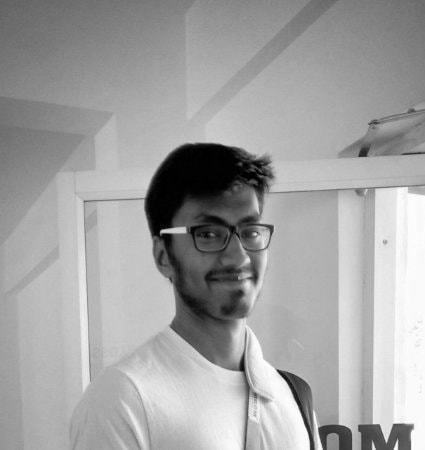

In [277]:
new_content_image

In [280]:
STYLE_NEW = 'style_2.jpg'

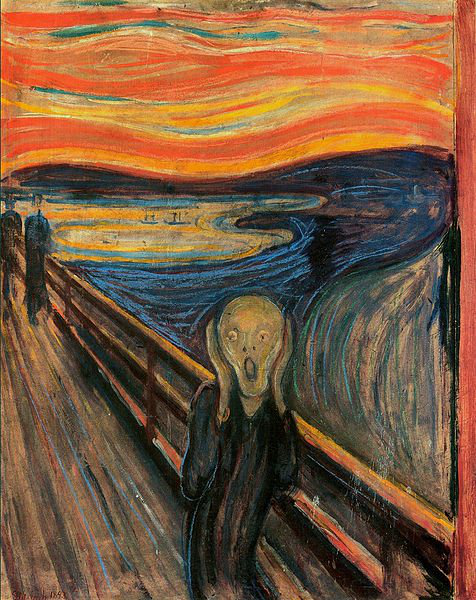

In [281]:
new_style_image = Image.open(PATH+STYLE_NEW);new_style_image

In [282]:
temp = img_to_array(new_content_image)
temp.shape

(450, 425, 1)

Preprocessing a grayscale image

In [283]:
new_content_arr = preprocess_image(new_content_image)

In [284]:
new_content_shape = new_content_arr.shape
new_content_shape

(1, 450, 425, 3)

Let us now resize the style image to be the same as our content image.

In [285]:
new_style_image = new_style_image.resize((new_content_shape[2], new_content_shape[1]))

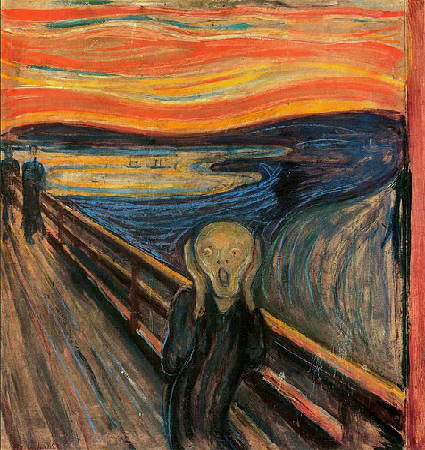

In [286]:
new_style_image

In [287]:
new_style_arr = preprocess_image(new_style_image)
new_style_shape = new_style_arr.shape
new_style_shape

(1, 450, 425, 3)

In [288]:
assert(new_style_shape == new_content_shape)

We need to get the VGG model again since the input shape has changed now.

In [289]:
base_vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=new_style_shape[1:])
base_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 450, 425, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 450, 425, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 450, 425, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 225, 212, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 225, 212, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 225, 212, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 112, 106, 128)     0         
__________

In [290]:
output_dict = {layer.name : layer.output for layer in base_vgg_model.layers}

In [291]:
output_layers = []
for i in range(1,6):
    if i ==1 or i ==2:
         layer_name = 'block'+str(i)+'_conv2'
    else:
        layer_name = 'block'+str(i)+'_conv3'
    output = output_dict[layer_name]
    output_layers.append(output)

In [292]:
output_layers

[<tf.Tensor 'block1_conv2_3/Relu:0' shape=(?, 450, 425, 64) dtype=float32>,
 <tf.Tensor 'block2_conv2_3/Relu:0' shape=(?, 225, 212, 128) dtype=float32>,
 <tf.Tensor 'block3_conv3_3/Relu:0' shape=(?, 112, 106, 256) dtype=float32>,
 <tf.Tensor 'block4_conv3_3/Relu:0' shape=(?, 56, 53, 512) dtype=float32>,
 <tf.Tensor 'block5_conv3_3/Relu:0' shape=(?, 28, 26, 512) dtype=float32>]

In [293]:
style_model = Model(inputs=base_vgg_model.input, outputs=output_layers)

In [294]:
style_targets = [K.variable(x) for x in style_model.predict(new_style_arr)]
content_targets = [K.variable(x) for x in style_model.predict(new_content_arr)]

Let us select the output of a single content image conv activations

In [295]:
style_losses = 0
style_wgts = [0.05,0.05,0.2,0.3,0.4]
#style_wgts = [1,1,1,1,1]
for act_layer, tar_layer, w in zip(output_layers, style_targets, style_wgts):
    curr_loss = K.mean(style_loss(act_layer[0], tar_layer[0]))
    style_losses = curr_loss*w + style_losses

In [296]:

content_losses = 0
content_wgts = [0.05,0.05,0.2,0.3,0.4]
#content_wgts = [1,1,1,1,1]
for act_layer, tar_layer, w in zip(output_layers, content_targets, content_wgts):
    curr_loss = K.mean(metrics.mse(act_layer[0], tar_layer[0]))
    content_losses = curr_loss*w + content_losses


In [306]:
alpha = 0.1
beta = 1

In [307]:
gc.collect()

4498

In [308]:
total_loss = alpha*content_losses + beta*style_losses
grads= K.gradients(total_loss, base_vgg_model.input)
total_loss_function = K.function([base_vgg_model.input], [total_loss] + grads)
mul_total_eval_obj = Evaluator(total_loss_function, new_style_shape)

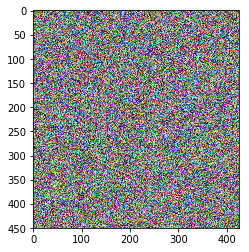

In [309]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)
x = rand_img(new_style_shape)
plt.imshow(x[0]);plt.show()

In [317]:
iterations = 15

In [318]:
x = solver(mul_total_eval_obj, iterations, x, new_style_shape, 'bb')

Iteration : 0
 Loss at iteration 0 is : 4532.22998047
Iteration : 1
 Loss at iteration 1 is : 4402.03320312
Iteration : 2
 Loss at iteration 2 is : 4291.80273438
Iteration : 3
 Loss at iteration 3 is : 4209.68603516
Iteration : 4
 Loss at iteration 4 is : 4134.12695312
Iteration : 5
 Loss at iteration 5 is : 4084.1965332
Iteration : 6
 Loss at iteration 6 is : 4024.05834961
Iteration : 7
 Loss at iteration 7 is : 3991.64331055
Iteration : 8
 Loss at iteration 8 is : 3955.9128418
Iteration : 9
 Loss at iteration 9 is : 3928.37548828
Iteration : 10
 Loss at iteration 10 is : 3903.95458984
Iteration : 11
 Loss at iteration 11 is : 3880.75610352
Iteration : 12
 Loss at iteration 12 is : 3865.4296875
Iteration : 13
 Loss at iteration 13 is : 3842.80395508
Iteration : 14
 Loss at iteration 14 is : 3829.97851562


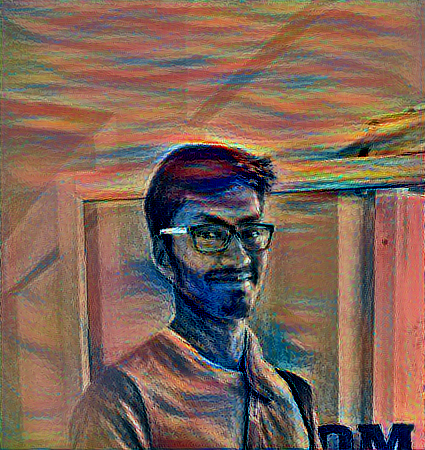

In [324]:
Image.open(RESULTS + 'res_at_iteration_bb_14.png')

In [320]:
def animate_mul_total(i):
    fname = RESULTS + 'res_at_iteration_bb_'+str(i)+'.png'
    ax.imshow(Image.open(fname))

In [321]:
anim = animation.FuncAnimation(fig, animate_mul_total, frames = 10, interval = 200)
HTML(anim.to_html5_video())

What if we start with the initial content or style image itself instead of random noise? Let's explore!

Starting with the content image.

In [322]:
x = solver(mul_total_eval_obj, iterations, new_content_arr, new_style_shape, 'bb_st_c')

Iteration : 0
 Loss at iteration 0 is : 8739.16601562
Iteration : 1
 Loss at iteration 1 is : 6142.00683594
Iteration : 2
 Loss at iteration 2 is : 5219.56494141
Iteration : 3
 Loss at iteration 3 is : 4772.77587891
Iteration : 4
 Loss at iteration 4 is : 4529.19384766
Iteration : 5
 Loss at iteration 5 is : 4363.81152344
Iteration : 6
 Loss at iteration 6 is : 4292.77978516
Iteration : 7
 Loss at iteration 7 is : 4200.18505859
Iteration : 8
 Loss at iteration 8 is : 4159.79345703
Iteration : 9
 Loss at iteration 9 is : 4098.01171875
Iteration : 10
 Loss at iteration 10 is : 4073.18432617
Iteration : 11
 Loss at iteration 11 is : 4031.23388672
Iteration : 12
 Loss at iteration 12 is : 3999.91308594
Iteration : 13
 Loss at iteration 13 is : 3970.19946289
Iteration : 14
 Loss at iteration 14 is : 3947.98803711


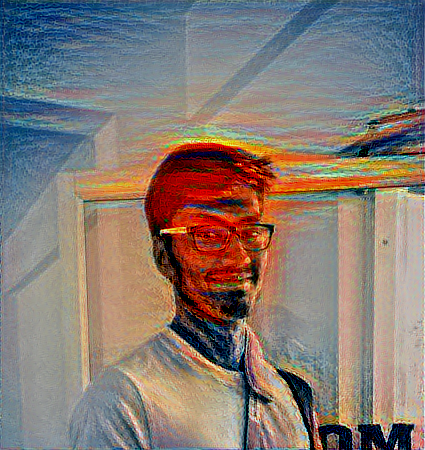

In [325]:
Image.open(RESULTS + 'res_at_iteration_bb_st_c_14.png')

In [326]:
def animate_mul_total_st_c(i):
    fname = RESULTS + 'res_at_iteration_bb_st_c_'+str(i)+'.png'
    ax.imshow(Image.open(fname))

anim = animation.FuncAnimation(fig, animate_mul_total_st_c, frames = 10, interval = 200)
HTML(anim.to_html5_video())

Starting with the style image.

In [327]:
x = solver(mul_total_eval_obj, iterations, new_style_arr, new_style_shape, 'bb_st_s')

Iteration : 0
 Loss at iteration 0 is : 5279.23632812
Iteration : 1
 Loss at iteration 1 is : 4718.34814453
Iteration : 2
 Loss at iteration 2 is : 4456.0625
Iteration : 3
 Loss at iteration 3 is : 4341.84814453
Iteration : 4
 Loss at iteration 4 is : 4253.22460938
Iteration : 5
 Loss at iteration 5 is : 4176.88623047
Iteration : 6
 Loss at iteration 6 is : 4127.53222656
Iteration : 7
 Loss at iteration 7 is : 4082.734375
Iteration : 8
 Loss at iteration 8 is : 4038.97436523
Iteration : 9
 Loss at iteration 9 is : 4011.35351562
Iteration : 10
 Loss at iteration 10 is : 3979.55200195
Iteration : 11
 Loss at iteration 11 is : 3957.94824219
Iteration : 12
 Loss at iteration 12 is : 3936.74169922
Iteration : 13
 Loss at iteration 13 is : 3920.92163086
Iteration : 14
 Loss at iteration 14 is : 3906.92211914


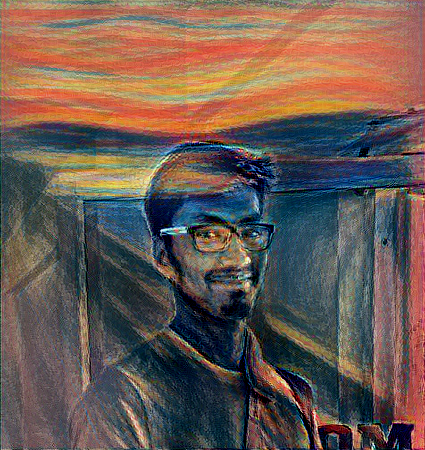

In [328]:
Image.open(RESULTS + 'res_at_iteration_bb_st_s_14.png')

In [329]:
def animate_mul_total_st_s(i):
    fname = RESULTS + 'res_at_iteration_bb_st_s_'+str(i)+'.png'
    ax.imshow(Image.open(fname))

anim = animation.FuncAnimation(fig, animate_mul_total_st_s, frames = 10, interval = 200)
HTML(anim.to_html5_video())